You can find my code on GitHub: https://github.com/MaximilianJHuber/NYU

Question 1
==

$$x_{t+1}=A_0x_t+Cw_{t+1}$$
$$y_{t+1}=Gx_t+Dw_{t+1}$$
with $x_t \in \mathbb{R}^n$, $y_t \in \mathbb{R}^m$ and $w_t \in \mathbb{R}^k$.

1.5.
--

This code borrows from QuantEcon's http://lectures.quantecon.org/jl/linear_models.html and http://lectures.quantecon.org/jl/kalman.html, but I have to adapt the functions due to the generalized setup here.

In [1]:
using Distributions 

type LSSgeneralized
    #matrices
    A::Matrix
    C::Matrix
    G::Matrix
    D::Matrix
    
    #dimensions
    k::Int
    n::Int
    m::Int
    
    #prior
    mu_0::Vector
    Sigma_0::Matrix
    dist::MultivariateNormal
    
    #filter
    x_hat_μ::Vector
    x_hat_Σ::Matrix
end

function LSSgeneralized(A::Matrix, C::Matrix, G::Matrix, D::Matrix, 
        mu_0::Array, Sigma_0::Matrix)
    m = size(G, 1)
    n = size(G, 2)
    k = size(C, 2)
    
    return LSSgeneralized(A,C,G,D,k,n,m,mu_0,Sigma_0,MultivariateNormal(mu_0, Sigma_0),
        mu_0, Sigma_0)
end

LSSgeneralized

Mind: $(x_t,y_{t+1})$.

In [2]:
function simulate(lss::LSSgeneralized, ts_length=100;x_init=rand(lss.dist))
    x = Array(Float64, lss.n, ts_length)
    y = Array(Float64, lss.m, ts_length)
    x[:, 1] = x_init
    
    w = randn(lss.k, ts_length - 1)
    for t=1:ts_length-1
        y[:, t] = lss.G * x[:,t] .+ lss.D * w[:, t]
        x[:, t+1] = lss.A * x[:, t] .+ lss.C * w[:, t]
    end
    
    y[:,end] = NaN*zeros(lss.m)    #last observation is not defined!

    return (x', y')
end

simulate (generic function with 2 methods)

Mind that $\hat{x}_t$ is a nowcast! The function "prior_to_nowcast" takes a single $y_t$ observation and does the update.

In [3]:
function prior_to_nowcast!(k::LSSgeneralized, y::Vector)

    K = (k.A*k.x_hat_Σ*k.G' + k.C*k.D')*inv(k.G*k.x_hat_Σ*k.G'+k.D*k.D')
    
    k.x_hat_μ = k.A*k.x_hat_μ+K*(y-k.G*k.x_hat_μ)
    k.x_hat_Σ = (k.A-K*k.G)*k.x_hat_Σ*(k.A-K*k.G)' + (k.C-K*k.D)*(k.C-K*k.D)'
    
    Void
end

prior_to_nowcast! (generic function with 1 method)

The function "kalmanian" takes a whole time series, with one observation per row.

In [4]:
function kalmanian(k::LSSgeneralized, y::Matrix)
    
    T=size(y,1)
    Xhat = Array(MultivariateNormal,T)

    k.x_hat_μ = k.dist.μ  #reset
    k.x_hat_Σ = full(k.dist.Σ)  #reset
    
    for i in 1:size(y,1)
        prior_to_nowcast!(k,y[i,:])
        Xhat[i] = MultivariateNormal(k.x_hat_μ, k.x_hat_Σ)
    end
    
    return Xhat
end

kalmanian (generic function with 1 method)

In [5]:
function state_likelihood(k::LSSgeneralized, x::Matrix)
    T = size(x,1)
    return sum([log(pdf(MultivariateNormal(k.A*x[t-1,:],k.C*k.C'), x[t,:])) for t in 2:T]) +
                log(pdf(k.dist,x[1,:]))
end

state_likelihood (generic function with 1 method)

In [6]:
function observation_likelihood(k::LSSgeneralized, y::Matrix)
    T = size(y,1)
    
    Xhat = kalmanian(k,y)
    return sum([
        log(pdf(MultivariateNormal(k.G*Xhat[t-1].μ,k.G*full(Xhat[t-1].Σ)*k.G' + 
            k.D*k.D'), y[t,:])) 
        for t in 2:T-1])
end

observation_likelihood (generic function with 1 method)

1.6
--

In [7]:
ρ=0.8; σ1=0.02; σ2=0.05; σ3=0.03;

In [17]:
lss = LSSgeneralized([ρ 0; 0 0 ], [σ1 0 0; 0 σ2 0], [1 1], 
                     [0 0 σ3], [0, 0], [0.01 0; 0 0.01]);

In [36]:
data = simulate(lss,160);

In [37]:
Xhat = kalmanian(lss,data[2]);

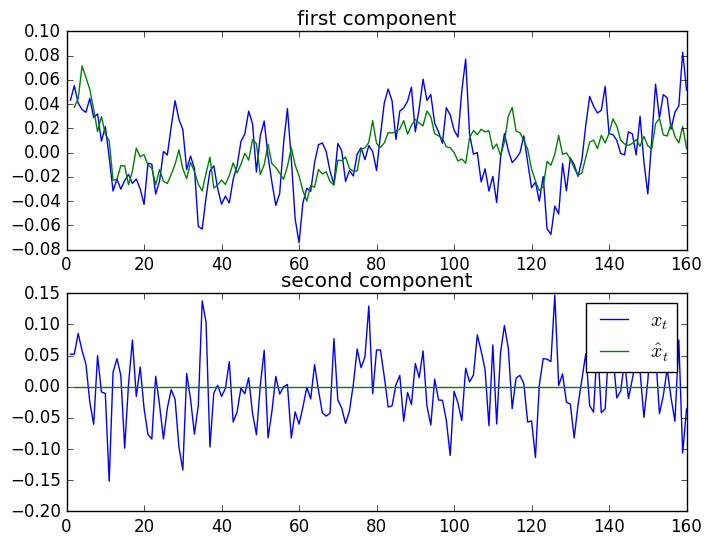

In [38]:
using PyPlot
subplot(211)
plot(1:160,data[1][:,1], label=L"$x_t$")
plot(2:161,[Xhat[t].μ[1] for t in 1:160], label=L"$\hat{x}_t$")
title("first component")
subplot(212)
plot(1:160,data[1][:,2], label=L"$x_t$")
plot(2:161,[Xhat[t].μ[2] for t in 1:160], label=L"$\hat{x}_t$")
title("second component");
legend(loc="upper right");

Nothing can be inferred about the transitory component, since there is not autocorrelation between $x_t^1$ and $x_t^2$.

1.7
--

In [39]:
ρ_grid = collect(linspace(0,1,101));

Given the sample of $x_t$ drawn above the likelihood maximizing $\rho$ is:

In [40]:
ρ_grid[indmax([state_likelihood(
    LSSgeneralized([ρstar 0; 0 0 ], [σ1 0 0; 0 σ2 0], 
        [1 1], [0 0 σ3], [0, 0], [0.01 0; 0 0.01]),
    data[1])
        for ρstar in ρ_grid])]

0.77

Given the sample of $y_t$ drawn above the likelihood maximizing $\rho$ is:

In [41]:
ρ_grid[indmax([observation_likelihood(
    LSSgeneralized([ρstar 0; 0 0 ], [σ1 0 0; 0 σ2 0], 
        [1 1], [0 0 σ3], [0, 0], [0.01 0; 0 0.01]),
    data[2])
        for ρstar in ρ_grid])]

0.82

Quite good fit!

Question 2
==
2.19
--

In [42]:
iq = LSSgeneralized(reshape([1],1,1),reshape([0],1,1), reshape([1],1,1), 
        reshape([10],1,1), [100], reshape([10.],1,1));

In [46]:
data = simulate(iq,51,x_init=100.);

In [47]:
Xhat = kalmanian(iq,data[2]);

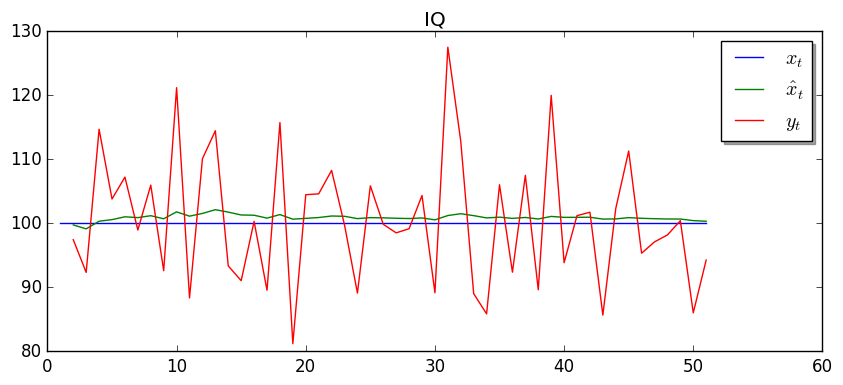

In [48]:
figure(figsize=[10,4])
plot(1:size(data[1],1),data[1][:,1], label=L"$x_t$")
plot((1:size(data[1],1))+1,[Xhat[t].μ[1] for t in 1:size(data[1],1)], label=L"$\hat{x}_t$")
plot((1:size(data[1],1))+1,data[2][:,1], label=L"$y_t$")
title("IQ");
legend(loc="upper right", shadow=true);

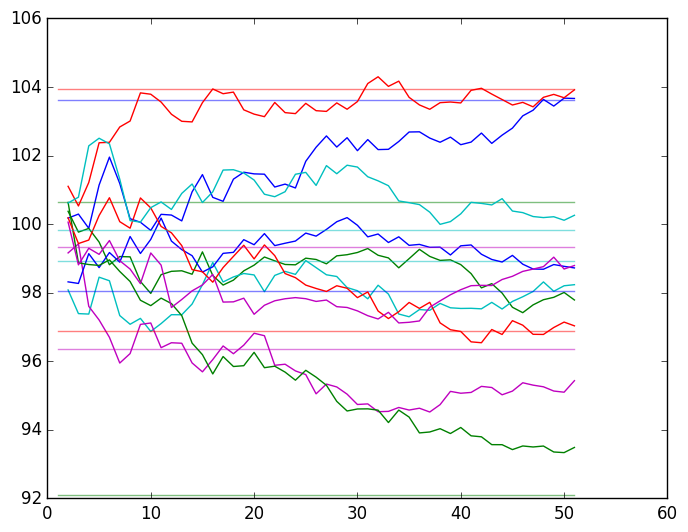

In [49]:
cols = ["b", "g", "r", "c", "m", "b", "g", "r", "c", "m"]

for i in 1:10
    data = simulate(iq,51)
    Xhat = kalmanian(iq,data[2]);
    plot((1:size(data[1],1))+1,[Xhat[t].μ[1] for t in 1:size(data[1],1)], 
        label=L"$\hat{x}_t$", color=cols[i])
    plot(1:length(data[1]),data[1], color=cols[i], alpha=0.5)
end

Let's take a look at how $\Sigma$ evolves over time:

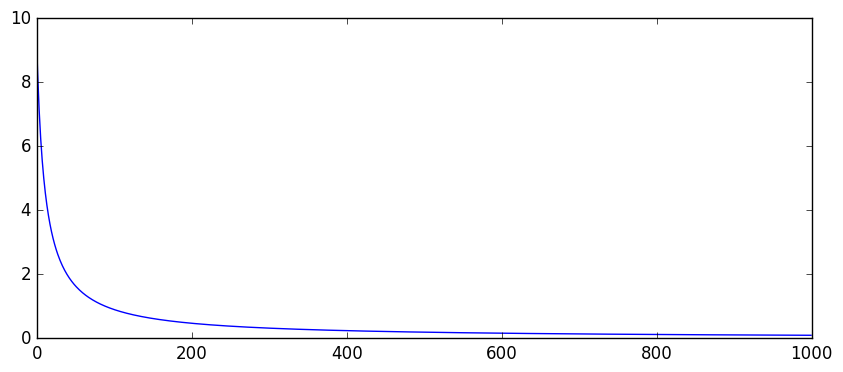

In [50]:
data = simulate(iq, 1000)
Xhat = kalmanian(iq, data[2]);
figure(figsize=[10, 4])
plot([maximum(abs(full(Xhat[t].Σ)[:])) for t in 1:1000]);

2.26
--
I guess I have to change all the functions, yet again!

In [51]:
even(n) = n == 0 ? true  :  odd(n-1)
odd(n)  = n == 0 ? false : even(n-1)

function simulateG(lss::LSSgeneralized, Godd::Matrix, Geven::Matrix, 
                   ts_length=100;x_init=rand(lss.dist))
    x = Array(Float64, lss.n, ts_length)
    y = Array(Float64, lss.m, ts_length)
    x[:, 1] = x_init
    
    w = randn(lss.k, ts_length - 1)
    for t=1:ts_length-1 #t=1 is x_0, y_1
        if even(t) 
            y[:, t] = Geven * x[:,t] .+ lss.D * w[:, t]
        else
            y[:, t] = Godd * x[:,t] .+ lss.D * w[:, t]
        end
        x[:, t+1] = lss.A * x[:, t] .+ lss.C * w[:, t]
    end
    
    y[:,end] = NaN*zeros(lss.m)    #last observation is not defined!

    return (x', y')
end

function kalmanian(k::LSSgeneralized, y::Matrix, Godd::Matrix, Geven::Matrix)
    
    T=size(y,1)
    Xhat = Array(MultivariateNormal,T)

    k.x_hat_μ = k.dist.μ  #reset
    k.x_hat_Σ = full(k.dist.Σ)  #reset
    
    for t in 1:size(y,1)
        if even(t) 
            k.G = Geven
        else 
            k.G = Godd
        end
        prior_to_nowcast!(k,y[t,:])
        k.x_hat_Σ[2,1] = k.x_hat_Σ[1,2]
        Xhat[t] = MultivariateNormal(k.x_hat_μ, k.x_hat_Σ)
    end
    
    return Xhat
end

kalmanian (generic function with 2 methods)

In [52]:
Geven = [0.9 0.1]
Godd = [0.01 0.99]
iq2 = LSSgeneralized([1 0; 0 1], [0 0; 0 0], [0.9 0.1], [sqrt(50) 0],
            [100, 100], [10. 0; 0 10.]);

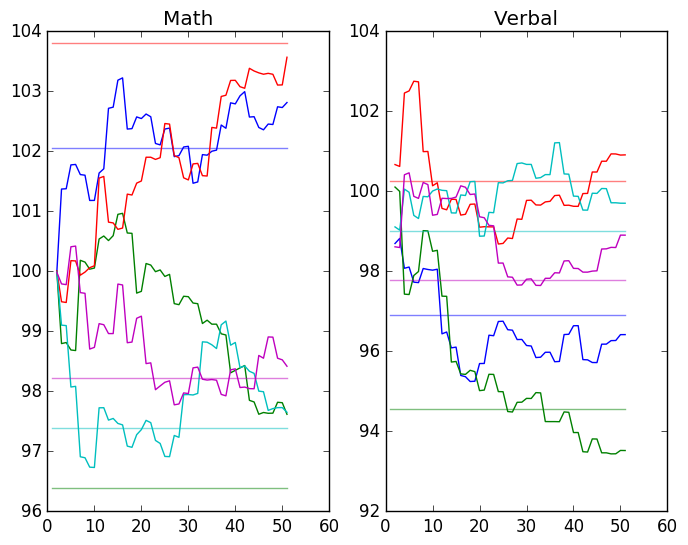

In [53]:
cols = ["b", "g", "r", "c", "m"]

for i in 1:5
    data = simulateG(iq2, Godd, Geven, 51)
    Xhat = kalmanian(iq2, data[2], Godd, Geven)
    subplot(121)
    plot((1:size(data[1],1))+1,[Xhat[t].μ[1] for t in 1:size(data[1],1)], 
        label=L"$\hat{x}_t$", color=cols[i])
    plot(1:size(data[1],1),data[1][:,1], color=cols[i], alpha=0.5)
    title("Math")
    subplot(122)
    plot((1:size(data[1],1))+1,[Xhat[t].μ[2] for t in 1:size(data[1],1)], 
        label=L"$\hat{x}_t$", color=cols[i])
    plot(1:size(data[1],1),data[1][:,2], color=cols[i], alpha=0.5)
    title("Verbal")
end

In [54]:
data = simulateG(iq2, Godd, Geven, 1000)
Xhat = kalmanian(iq2, data[2], Godd, Geven);

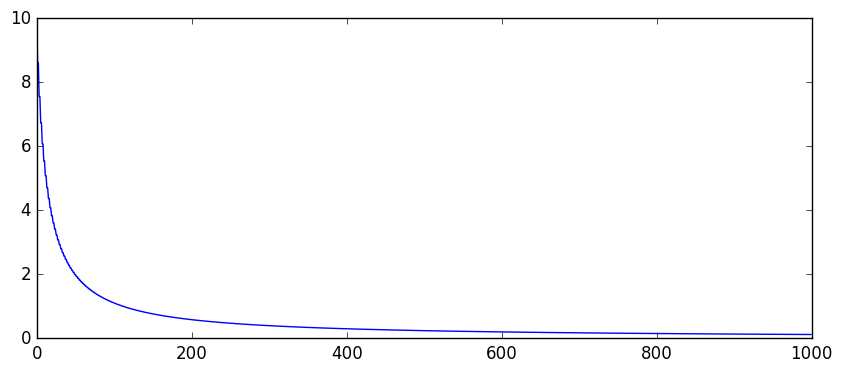

In [55]:
figure(figsize=[10, 4])
plot([maximum(abs(full(Xhat[t].Σ)[:])) for t in 1:1000]);

The $\Sigma_t$ matrix converges nicely!

Question 3
==
3.1
--
From a theory standpoint policy function iteration needs a good initial guess, whereas value function iteration (Banach's fixed point theorem) works for every starting value.
Practically, policy function iterations need far less runtime.
3.2
--
I use QuantEcon's type definition for LQ problems:
$$min \; \mathbb{E} \sum_{t=0}^{\infty} \beta^t r(x_t, u_t)$$
with $r(x_t, u_t) = x_t' R x_t + u_t' Q u_t + 2 u_t' N x_t$ s.t.
$$x_{t+1} = A x_t + B u_t + C w_{t+1}$$

In [57]:
using QuantEcon

In [58]:
function Howard_solve(lq::LQ, F0::Matrix; threshold=1e-10, max_iter=50)
    
    Fold = copy(F0)
    Fnew = 0.*Fold
    
    err = 1
    t = 0
    
    while err>=threshold && t <= max_iter
        t += 1
        #Value from following the policy Fold from tomorrow on: 
        P = solve_discrete_lyapunov(sqrt(lq.bet).*(lq.A-lq.B*Fold),lq.R + Fold'*lq.Q*Fold - 2*Fold'*lq.N)
        
        #today's optimal decision given that the old rule is obeyed from tomorrow on:
        Fnew = (lq.Q + lq.bet*lq.B'*P*lq.B)[1]^-1 * (lq.N + lq.bet*lq.B'*P*lq.A)
        
        err = maxabs(Fnew .- Fold)
        Fold = copy(Fnew)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    P = solve_discrete_lyapunov(sqrt(lq.bet).*(lq.A-lq.B*Fold),lq.R + Fold'*lq.Q*Fold + 2*Fold'*lq.N)
    σ = (1-lq.bet)^(-1)*lq.bet*(lq.C'*P*lq.C)
    
    return (P,Fnew,σ)
end

Howard_solve (generic function with 1 method)

5.3
--

In [59]:
β=0.05; r=β^(-1) - 1; b=30; γ=1.; ρ1=1.1; ρ2=-0.3;

#Q::ScalarOrArray, R::ScalarOrArray, A::ScalarOrArray,B::ScalarOrArray,C::ScalarOrArray,
#    N::ScalarOrArray,bet::ScalarOrArray=1.0
lq = LQ(1.+γ, [γ*r^2 γ*r 0 -b*γ*r; γ*r γ 0 -b*γ; 0 0 0 0; -b*γ*r -b*γ 0 γ*b^2], 
        [1+r 1 0 -b; 0 ρ1 ρ2 0; 0 1 0 0; 0 0 0 1], [-1.; 0; 0; 0], [0.; 0; 0; 0], [-r -1 0 -1], β);

In [61]:
@time Howard_solve(lq,[-16 -0.8 0.1 20]);

  0.001284 seconds (7.96 k allocations: 716.484 KB)


The policy function iteration needs good initial values in order to converge.

Using QuantEcon's method uses the value function iteration (which leads to solving a Riccati equation):

In [63]:
@time (P,F,d) = stationary_values(lq)

  0.000589 seconds (991 allocations: 157.406 KB)


(
[380.0 20.0899 -0.301348 -1220.0; 20.0899 1.06214 -0.0159956 -64.4991; -0.301348 -0.0159956 0.000455302 0.967486; -1220.0 -64.4991 0.967486 2905.26],

[-19.0 -1.00428 0.0143499 30.0],

0.0)

The method does not need a good initial value, but solving takes marginally longer.

In [64]:
-F

1×4 Array{Float64,2}:
 19.0  1.00428  -0.0143499  -30.0

The solution is $c_t = u_t + 30 \approx 19 a_t + y_t - 0.014 y_{t-1}$. The higher the assets and the income the higher the consumption. But the mean reverting income makes the agent put a negative loading on last periods income.

5.4
--
b.
--
In the durable goods case utility is mainly derived from the stock, the loading on current consumption is low. Today's consumption increases tomorrows stock one-to-one.

In [65]:
λ=1; π=0.05; δ=0.95; θ=1;

lq = LQ(1.+γ/π, [γ*r^2 γ*r 0 (γ+b)/(π*2) γ*r*γ/π; γ*r γ 0 γ/(π*2) γ*λ/π; 0 0 0 0 0; 
        (γ+b)/(π*2) γ/(π*2) 0 γ*b^2/(pi^2) γ*λ/π; γ*r*γ/π γ*λ/π 0 γ*λ/π γ*λ^2/(π^2)], 
        [1+r 1 0 -b/π λ/π; 0 ρ1 ρ2 0 0; 0 1 0 0 0; 0 0 0 1 0; 0 0 0 θ*b/π δ-θ*λ/π], 
[-1/π; 0; 0; 0; θ/π], [0.; 0; 0; 0; 0], [-γ*r/π -γ/π 0 -γ*b/(π^2) -γ*b/(π^2)], β);

In [67]:
@time (P,F,d) = stationary_values(lq);

  0.002371 seconds (1.08 k allocations: 208.047 KB)


In [68]:
-F

1×5 Array{Float64,2}:
 1.02432  0.054154  -0.000812344  -30.0013  0.999804

The solution is $s_t \approx 1.02 a_t + 0.05 y_t - 0.001 y_{t-1} + h_t$ and hence $c_t \approx 20.8 a_t + 1.08 y_t - 0.2 y_{t-1}$. The agent consumes more than in Q5.3, because "investing" in the durable good pays off more in utility  than investing in the asset. Hence, asset levels will be lower here!

c.
--

In the habits case utility is decreased by past habits, which decay only slowly. I expect the agent to consume less and save more in assets!

In [69]:
λ=-1; π=1; δ=0.95; θ=1;

lq = LQ(1., [0 0 0 sqrt(γ*r) 0; 0 0 0 sqrt(γ) 0; 0 0 0 0 0; sqrt(γ*r) sqrt(γ) 0 0 γ*λ/π; 0 0 0 0 0], 
        [1+r 1 0 -b/π λ/π; 0 ρ1 ρ2 0 0; 0 1 0 0 0; 0 0 0 1 0; 0 0 0 θ*b/π δ-θ*λ/π], 
        [-1/π; 0; 0; 0; θ/π], [0.; 0; 0; 0; 0], [0 0 0 -γ/π 0], β);

In [71]:
@time (P,F,d) = stationary_values(lq);

  0.001279 seconds (1.14 k allocations: 216.203 KB)


In [72]:
-F

1×5 Array{Float64,2}:
 18.0026  0.951764  -0.0142765  -29.9879  -0.997375

The solution is $s_t \approx 18 a_t + 0.95 y_t - 0.014 y_{t-1} - h_t$ and hence $c_t \approx 18 a_t + 0.95 y_t - 0.014 y_{t-1}$. The agent consumes less and saves more than before!

5.13
--
I take $u_t = c_t - b$ and $x_t = [a_t, y_t, y_{t-1}, 1]'$
b.
--

In [73]:
b=1000; β=0.95; R=β^-1; ρ1=1.2; ρ2=-0.4; σy=0.05; ϵ=0.0001;

lq = LQ(1., [sqrt(ϵ) 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 0], 
        [R 1 0 -b; 0 ρ1 ρ2 1-ρ1-ρ2; 0 1 0 0; 0 0 0 1], [-1.; 0; 0; 0], [0.; σy; 0; 0], [0 0 0 0], β);

In [75]:
@time (P,F,d) = stationary_values(lq);

  0.000606 seconds (1.27 k allocations: 184.313 KB)


In [76]:
-F

1×4 Array{Float64,2}:
 0.123865  0.465828  -0.164405  -999.301

The solution is $c_t \approx 0.07 a_t + 0.28 y_t - 0.1 y_{t-1}$.
c.
--

In [78]:
eig([R 1 0 -b; 0 ρ1 ρ2 1-ρ1-ρ2; 0 1 0 0; 0 0 0 1]-[-1.; 0; 0; 0]*F)

(Complex{Float64}[0.928767+0.0im,0.6+0.2im,0.6-0.2im,1.0+0.0im],
Complex{Float64}[1.0+0.0im -0.73703+0.0im -0.73703-0.0im -6.87581e-12+0.0im; 0.0+0.0im 0.326601-0.154408im 0.326601+0.154408im 0.57735+0.0im; 0.0+0.0im 0.412698-0.394913im 0.412698+0.394913im 0.57735+0.0im; 0.0+0.0im 0.0+0.0im 0.0-0.0im 0.57735+0.0im])

One eigenvalue is exactly one!
d.
--

In [79]:
b=1000; β=0.95; R=β^-1; ρ1=1.2; ρ2=-0.4; σy=0.05; ϵ=0.0;

lq = LQ(1., [sqrt(ϵ) 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 0], 
        [R 1 0 -b; 0 ρ1 ρ2 1-ρ1-ρ2; 0 1 0 0; 0 0 0 1], [-1.; 0; 0; 0], [0.; σy; 0; 0], [0 0 0 0], β);

In [80]:
(P,F,d) = stationary_values(lq);
-F

1×4 Array{Float64,2}:
 -0.0  -0.0  -0.0  -0.0

Not sure what to make of this...

Question 4
==
4.3
--
I use the QuantEcon functions on LQ control: http://lectures.quantecon.org/jl/lqcontrol.html.


In [81]:
r=0.05; β=1/(1+r); c_bar=1.5; μ=2; σ=0.15; T=50; q=1e4;
m1=T*μ/(T/2)^2; m2=-μ/(T/2)^2;
A=[1+r -c_bar m1 m2; 0 1 0 0; 0 1 1 0; 0 1 2 1]
B=[-1; 0; 0; 0]
C=[σ; 0; 0; 0]
R=zeros(4,4)
R_T=zeros(4,4); R_T[1,1] = q;
Q=reshape([1],1,1)
H=[0; 0; 0; 0];

In [82]:
lq = LQ(Q, R, A, B, C; bet = β, capT = T, rf = R_T);

The function "compute_sequence" solves the LQ problem backwards and saves the policy matrix in each step. Then it simulates the system given initial state and policies using normally distributed errors $w_t$.

In [83]:
x0 = [0.0; 1.0; 0.0; 0.0]
xp, up, wp = compute_sequence(lq, x0);

In [84]:
assets = xp[1,:]
cons = vec(up + c_bar)
time = collect(1:T)
income = wp[1,2:end] + m1 .* time + m2 * time.^2;

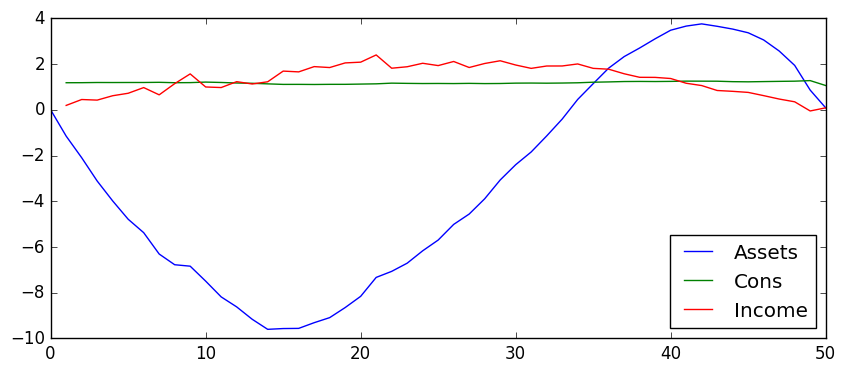

In [85]:
figure(figsize=[10,4])
plot([0; time],assets,label="Assets")
plot(time,cons,label="Cons")
plot(time,income,label="Income")
legend(loc="lower right");

The agent takes out quite a lot of debt in the early age to finance a almost perfectly smoothed consumption path. The minor wiggles come from partially compensating for income shocks. The lion share of debt is payed back in the middle age. Retirement savings peak at about three times the mean consumption.